<a href="https://colab.research.google.com/github/emilstahl97/Scalable-Machine-Learning-and-Deep-Learning-ID2223/blob/notebooks/SpeechRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Speech Emotion Detection

#### RAVDESS Dataset:

- The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) is licensed under CC BY-NA-SC 4.0. and can be downloaded free of charge at https://zenodo.org/record/1188976.
- The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). 
- The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. 
- Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. 
- Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. - All conditions are available in three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound).  

For this analysis, the below file types have been used:
- Audio speech files. 
- Additionally, the speech from the video files have been extracted by converting the MP4 files to WAV format.

File naming convention: Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

Filename identifiers 
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [1]:
from google.colab import drive
import os

# README - Execute this cell to mount the notebook in your google drive. 
# Execute the cell and follow the link to sign and, paste the given key in the little text box. The credentials are only available for you. 

drive.mount('/content/drive', force_remount=True)

if not os.path.exists("/content/drive/MyDrive/audio-dataset"):
  print("Pulling dataset")
  os.makedirs("/content/drive/MyDrive/audio-dataset")
  !git clone https://github.com/emilstahl97/Audio-dataset.git
else:
  print("Dataset already exists")

os.chdir("/content/drive/MyDrive/audio-dataset")
#os.chdir("/content/drive/MyDrive/audio-dataset/Audio-dataset/Audio-dataset")
#os.chdir("/content/drive/MyDrive/audio-dataset/Audio-dataset/Rawdata")

!git pull
!ls

RAVDESS_PATH = "./RAVDESS"
SAVEE_PATH = "./SAVEE"
SAVED_MODELS_PATH = "../saved_models"

if not os.path.exists("/content/drive/MyDrive/ID2223/project/mfcc"):
  os.makedirs("/content/drive/MyDrive/ID2223/project/mfcc/")
  
if not os.path.exists("/content/drive/MyDrive/ID2223/project/emotion"):
  os.makedirs("/content/drive/MyDrive/ID2223/project/emotion/")

mfcc_file_path = "/content/drive/MyDrive/ID2223/project/mfcc/mfcc.npy"
emotion_file_path = "/content/drive/MyDrive/ID2223/project/emotion/emotion.npy"
path_AudioFiles = './RAVDESS'

Mounted at /content/drive
Dataset already exists
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
RAVDESS


In [2]:
!pip install --upgrade tensorflow_hub
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install --upgrade numpy
!pip install --upgrade matplotlib
!pip install --upgrade librosa
!pip install --upgrade scipy
!pip install --upgrade scikit-learn
!pip install --upgrade pandas

In [3]:
# Import libraries 
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  
import os
import sys
import warnings
import subprocess

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


### Explore the Data

In [4]:
# Define a function to generate MFCC from the audio files

def fn_MFCC_Emotion(v_path_AudioFiles):
    "Feature Generation: MFCC and Emotion"
    print("in mfcc")
    i = 0
    for path in [v_path_AudioFiles]:
        for root, dirs, files in os.walk(path):
            for name in files:
                i = i + 1
                print(name, i)

                X, sample_rate = librosa.load(os.path.join(str(root),str(name)), res_type='kaiser_fast')  
                v_mfcc = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 

                v_emotion = int(name[7:8]) - 1 
                
                lst_mfcc.append(v_mfcc)
                lst_emotion.append(v_emotion)
    return lst_mfcc, lst_emotion

In [5]:
import os

lst_mfcc = []
lst_emotion = []
mfcc = []
emotion = []

if not os.path.exists(mfcc_file_path) or not os.path.exists(emotion_file_path):
    print("Running fn_MFCC_Emotion...")
    %time mfcc, emotion =  fn_MFCC_Emotion(path_AudioFiles)

    print(mfcc[0:3], emotion[0:3])

    np.save(mfcc_file_path, mfcc)
    np.save(emotion_file_path, emotion)
  
  
elif os.path.exists(mfcc_file_path) and os.path.exists(emotion_file_path):
  print("Loading mfcc and emotion from local filesystem...")
  mfcc = np.load(mfcc_file_path, allow_pickle=True)
  emotion = np.load(emotion_file_path, allow_pickle=True)

X = np.array(mfcc)
y = np.array(emotion)

print(X.shape, y.shape)

Loading mfcc and emotion from local filesystem...
(2884, 40) (2884,)


In [6]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

### Model 1: Decision Tree

In [7]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf = 3, 
                                 random_state= 9)

%time dt.fit(X_train, y_train)

CPU times: user 217 ms, sys: 3.71 ms, total: 221 ms
Wall time: 220 ms


DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3,
                       random_state=9)

In [8]:
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64        59
           1       0.69      0.71      0.70       119
           2       0.53      0.58      0.56       133
           3       0.45      0.62      0.52        89
           4       0.66      0.71      0.68       106
           5       0.73      0.61      0.66       132
           6       0.62      0.49      0.55       117
           7       0.50      0.47      0.48       111

    accuracy                           0.60       866
   macro avg       0.60      0.60      0.60       866
weighted avg       0.61      0.60      0.60       866



### Model 2: Random Forest

In [9]:
rf = RandomForestClassifier(criterion="gini", max_depth=10, max_features="sqrt", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 20000, random_state= 9)

%time rf.fit(X_train, y_train)

CPU times: user 2min 49s, sys: 1.04 s, total: 2min 50s
Wall time: 2min 49s


RandomForestClassifier(max_depth=10, max_features='sqrt', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=20000, random_state=9)

In [10]:
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.44      0.61        59
           1       0.77      1.00      0.87       119
           2       0.90      0.71      0.80       133
           3       0.68      0.84      0.75        89
           4       0.89      0.87      0.88       106
           5       0.83      0.78      0.80       132
           6       0.80      0.81      0.81       117
           7       0.72      0.80      0.76       111

    accuracy                           0.80       866
   macro avg       0.82      0.78      0.78       866
weighted avg       0.82      0.80      0.80       866



### Model 3: XGBoost

In [11]:
XGB = XGBClassifier(n_estimators=2000, gamma=0.5,learning_rate=0.1, max_depth = 10)

%time XGB.fit(X_train, y_train)

CPU times: user 3min 34s, sys: 727 ms, total: 3min 35s
Wall time: 3min 34s


XGBClassifier(gamma=0.5, max_depth=10, n_estimators=2000,
              objective='multi:softprob')

In [12]:
y_pred = XGB.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81        59
           1       0.91      0.97      0.93       119
           2       0.91      0.92      0.92       133
           3       0.81      0.98      0.89        89
           4       0.91      0.92      0.92       106
           5       0.89      0.88      0.89       132
           6       0.94      0.88      0.91       117
           7       0.86      0.80      0.83       111

    accuracy                           0.89       866
   macro avg       0.89      0.89      0.89       866
weighted avg       0.90      0.89      0.89       866



### Model 4: CNN (Convolutional  Neural Network)

In [13]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

X_train.shape, X_test.shape

((2018, 40, 1), (866, 40, 1))

In [14]:

from tensorflow.keras import optimizers

model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1))) 
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8)) 
model.add(Activation('softmax'))
opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 256)           2304      
                                                                 
 activation (Activation)     (None, 40, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 256)           524544    
                                                                 
 batch_normalization (BatchN  (None, 40, 256)          1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 40, 256)           0         
                                                                 
 dropout (Dropout)           (None, 40, 256)           0         
                                                        

In [16]:
def save_model(model):
    import os
    model_name = 'cnn.h5'
    save_dir = os.path.join(os.getcwd(), "/content/drive/MyDrive/savedmodels/")
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

    model_json = model.to_json()
    with open("/content/drive/MyDrive/savedmodels/model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("/content/drive/MyDrive/savedmodels/model.h5")
    print("Saved model to disk")

In [17]:
import os
from keras.models import model_from_json

if os.path.exists("/content/drive/MyDrive/savedmodels/cnn.h5"):
  print("Loading pre-trained model")
  model = keras.models.load_model("/content/drive/MyDrive/savedmodels/cnn.h5")
  json_file = open('/content/drive/MyDrive/savedmodels/model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights("/content/drive/MyDrive/savedmodels/model.h5")
  print("Loaded model from disk")


Loading pre-trained model
Loaded model from disk


In [19]:
  model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  cnn = model.fit(X_train, y_train, batch_size=1, epochs=2, validation_data=(X_test, y_test)) #should be bs 16 and 1000 epochs
  save_model(model)

Epoch 1/2
2018/2018 [==============================] - 50s 24ms/step - loss: 1.9228 - accuracy: 0.2418 - val_loss: 1.9495 - val_accuracy: 0.2309
Epoch 2/2
2018/2018 [==============================] - 45s 22ms/step - loss: 1.8944 - accuracy: 0.2671 - val_loss: 1.9231 - val_accuracy: 0.2517
Saved trained model at /content/drive/MyDrive/savedmodels/cnn.h5 
Saved model to disk


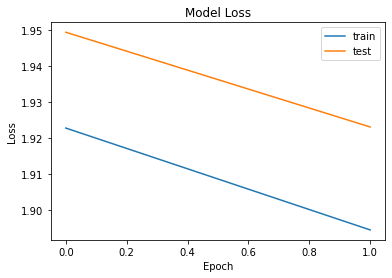

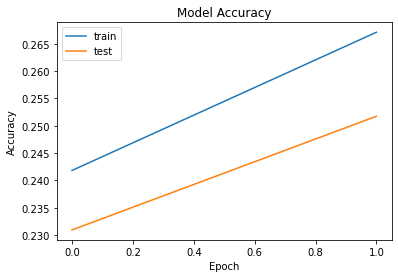

In [20]:
# Plot the model loss and accuracy 
plt.plot(cnn.history['loss'])
plt.plot(cnn.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(cnn.history['accuracy'])
plt.plot(cnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:

# Build lstm model
model = keras.Sequential()
model.add(keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(8, activation='softmax'))

In [27]:
# Compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
Total params: 54,600
Trainable params: 54,600
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Train and evaluate model
lstm = model.fit(X_train, y_train, batch_size=16, epochs=1000, validation_data=(X_test, y_test))
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('LSTM model test accuracy: ', acc)

Epoch 1/1000
127/127 [==============================] - 10s 52ms/step - loss: 2.0791 - accuracy: 0.1189 - val_loss: 2.0734 - val_accuracy: 0.1432
Epoch 2/1000
127/127 [==============================] - 6s 45ms/step - loss: 2.0785 - accuracy: 0.1224 - val_loss: 2.0717 - val_accuracy: 0.1432
Epoch 3/1000
127/127 [==============================] - 6s 46ms/step - loss: 2.0711 - accuracy: 0.1189 - val_loss: 2.0699 - val_accuracy: 0.1420
Epoch 4/1000
127/127 [==============================] - 6s 45ms/step - loss: 2.0718 - accuracy: 0.1333 - val_loss: 2.0681 - val_accuracy: 0.1478
Epoch 5/1000
127/127 [==============================] - 6s 45ms/step - loss: 2.0688 - accuracy: 0.1313 - val_loss: 2.0663 - val_accuracy: 0.1524
Epoch 6/1000
127/127 [==============================] - 6s 46ms/step - loss: 2.0703 - accuracy: 0.1343 - val_loss: 2.0649 - val_accuracy: 0.1524
Epoch 7/1000
127/127 [==============================] - 6s 45ms/step - loss: 2.0664 - accuracy: 0.1442 - val_loss: 2.0636 - val_a

#MLP


In [40]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(activation='relu', solver='adam', random_state=1)
nsamples, nx, ny = X_train.shape
d1_X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
d2_X_test = X_test.reshape((nsamples,nx*ny))

mlp.fit(d1_X_train, y_train)
mlp.score(d2_X_test, y_test)


0.48498845265588914

####                                                                                THANK YOU !!